# 어울리는 의상 찾기
---

## 실험 환경
- 이 노트북은 SageMaker Studio Code Editor 및 커널 base (Python 3.10.13) 에서 테스트 되었습니다.
- 실행 환경에 설치된 Python Package 참고 하세요. --> [requirements.txt](../requirements.txt)

## 참고 자료
- [Building with Anthropic’s Claude 3 on Amazon Bedrock and LangChain](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)
- [Amazon Bedrock 기반 Amorepacific 리뷰 요약 서비스 평가 방법 구현하기](langchain_core.runnables.base.RunnableSequence)
- [Amazon Bedrock model IDs](https://docs.aws.amazon.com/bedrock/latest/userguide/model-ids.html)

---

# 1. 환경 셋업

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


상위 폴더의 경로를 추가하여 해당 유틸리티, 이미지 폴더를 참조 합니다.

In [16]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = ".."
add_python_path(module_path)

python path: /home/sagemaker-user/aws-ai-ml-workshop-kr-1/genai/aws-gen-ai-kr/20_applications/05_image_styling_recommendation_with_prompt_engineering/evaluation already exists
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr-1/genai/aws-gen-ai-kr/20_applications/05_image_styling_recommendation_with_prompt_engineering/evaluation/notebook', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/opt/conda/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr-1/genai/aws-gen-ai-kr/20_applications/05_image_styling_recommendation_with_prompt_engineering/evaluation']


In [17]:
import os
import boto3
import json
# import eval_utils.bedrock_runtime_wrapper



Amazon Bedrock Claude3 모델을 사용 지역 및 모델 아이디 지정 합니다. 또한 Boto3 SDK 를 활용하는 Client 를 가져 옵니다

In [18]:

region = "us-west-2"
claude3_model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

client = boto3.client(service_name="bedrock-runtime", region_name=region)


# 2. 상품 이미지 보여주기

In [19]:
from eval_utils.util import (
                        set_body,
                        invoke_claude3_sonnet_model, 
                        extract_properties_from_image,
                        encoding_image,
                        get_files_in_folder,
                        parse_output_select_reason
)

## 이미지 경로 로딩 하기

In [20]:
# Get sample directory files

sample_directory = "sample_00"
sample_folder_path = f'../samples/{sample_directory}/'

all_items = get_files_in_folder(folder_path = sample_folder_path)
print(all_items)



{'target': '../samples/sample_00/target_jean_shirt_female.jpeg', 'associates': ['../samples/sample_00/style_shop_candidate01.jpg', '../samples/sample_00/simple_date_look_candidate02.jpeg', '../samples/sample_00/tshirt_female_candidate03.jpg']}


## 이미지 로딩 및 속성 추출
- 아래와 같이 프롬프트를 작성하고, 이미지를 로딩하여 속성을 추출 합니다. 
- 첫번째 이미지는 타겟 이미지이고, 나머지 3개의 이미지는 코디를 할 후보 이미지 입니다.
    - 원본 이미지의 경로는 아래와 같습니다.
        - 타켁이미지: [Name: W DENIM TRUCKER JACKET light blue](https://www.musinsa.com/app/goods/3820872?loc=goods_rank)
        - 후보 이미지 1: [Name: Brand Sna](https://www.musinsa.com/mz/brandsnap/view/411491)
        - 후보 이미지 2: [Name: 깔끔한 데이트 룩](https://www.musinsa.com/app/styles/views/41495?use_yn_360=&style_type=&brand=&tag_no=&display_cnt=60&list_kind=big&sort=NEWEST&page=1)
        - 후보 이미지 3: [Name: 언제나 가장 중요한 것은 티셔츠](https://www.musinsa.com/cms/magazine/view/11456)
        

## This is target image
../samples/sample_00/target_jean_shirt_female.jpeg


- The model returned 1 response(s):
{
  "패션_분석": {
    "의류_아이템": "데님 재킷",
    "소재": "데님",
    "색상": "블루 데님",
    "스타일": "캐주얼",
    "디자인_요소": [
      {
        "요소": "칼라",
        "설명": "클래식한 데님 재킷 칼라"
      },
      {
        "요소": "포켓",
        "설명": "전형적인 데님 재킷 스타일의 가슴 포켓 2개"
      },
      {
        "요소": "단추",
        "설명": "데님 재킷 앞면에 여밈용 단추"
      },
      {
        "요소": "소매",
        "설명": "긴 소매의 전통적인 데님 재킷 디자인"
      }
    ]
  }
}


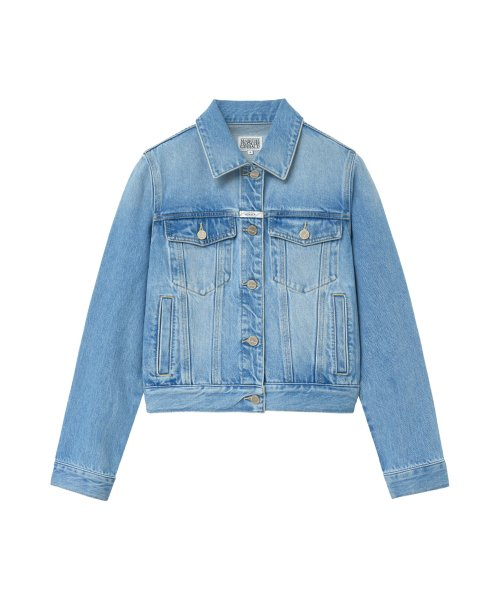

## This is candidate image
- The model returned 1 response(s):
{
  "의상 분석": [
    {
      "상의": "검은색 반팔 브이넥 니트",
      "하의": "진한 청색 와이드 데님 팬츠",
      "액세서리": "목걸이"
    },
    {
      "스타일": "캐주얼 스트리트 룩",
      "색상": ["검정색", "청색", "흰색"],
      "소재": ["니트", "데님"],
      "패턴": "단색"
    },
    {
      "특징": [
        "브이넥 디자인으로 여성스러움 강조",
        "와이드 팬츠로 편안한 실루엣 연출",
        "베이식한 색상 조합으로 단정한 느낌"
      ]
    }
  ]
}


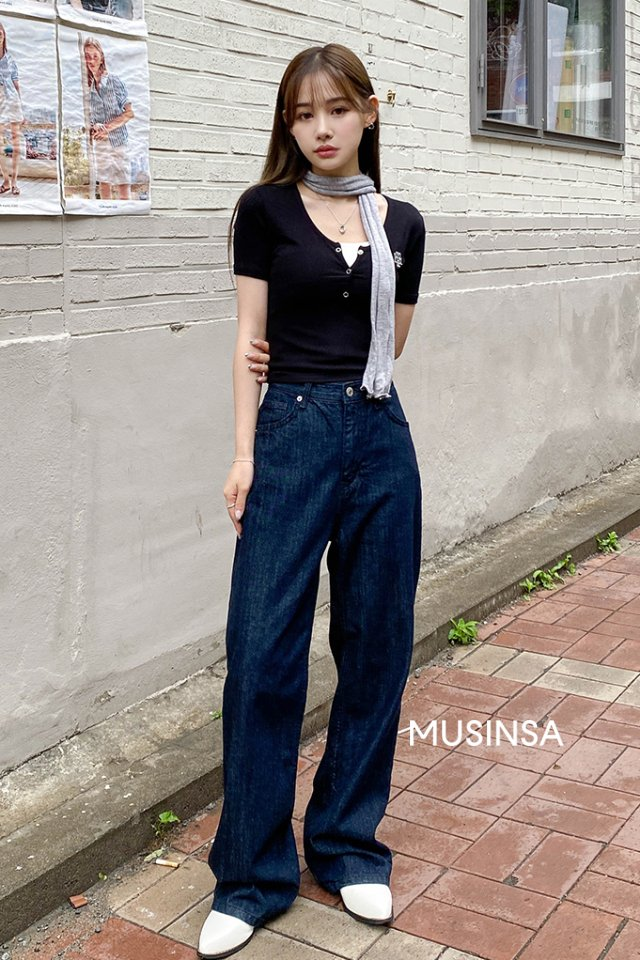

## This is candidate image
- The model returned 1 response(s):
{
  "패션 분석": [
    {
      "상의": {
        "종류": "터틀넥 스웨터",
        "소재": "니트",
        "색상": "검정색",
        "스타일": "슬림 핏"
      }
    },
    {
      "하의": {
        "종류": "미니 스커트",
        "소재": "면",
        "색상": "베이지색"
      }
    },
    {
      "신발": {
        "종류": "스니커즈",
        "색상": "흰색"
      }
    },
    {
      "가방": {
        "종류": "핸드백",
        "색상": "베이지색"
      }
    },
    {
      "헤어스타일": "긴 생머리"
    },
    {
      "전체 스타일": "캐주얼 모던"
    }
  ]
}


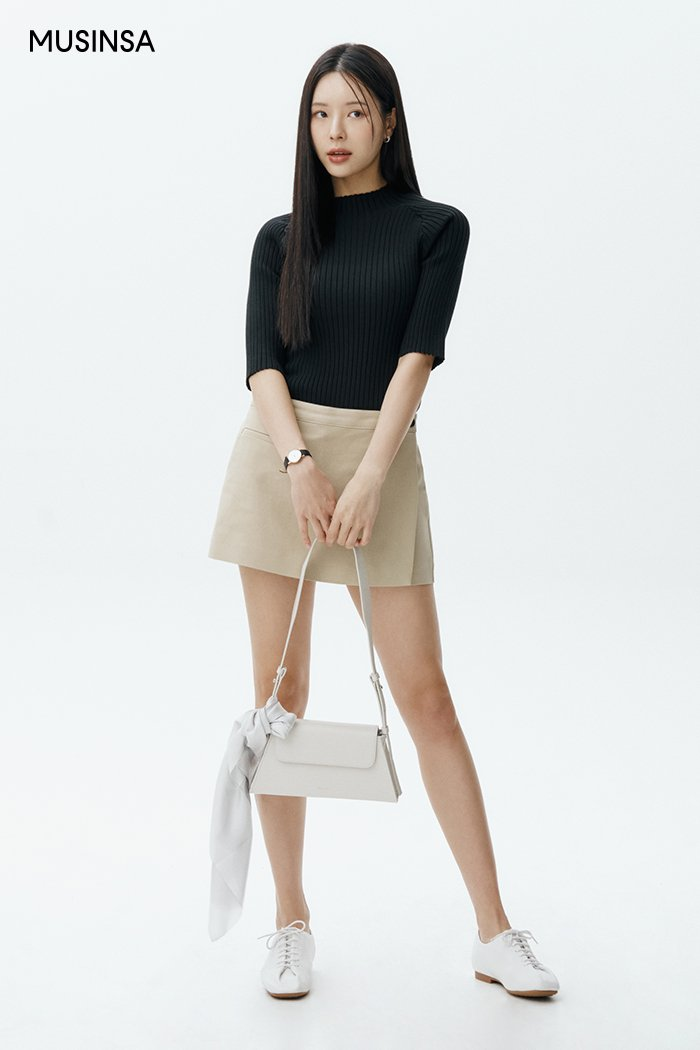

## This is candidate image
- The model returned 1 response(s):
{
  "패션 분석": {
    "상의": {
      "의류 품목": "반팔 티셔츠",
      "색상": "화이트",
      "소재": "면",
      "스타일": "심플하고 베이직한",
      "디테일": "가슴 부분에 'K' 로고 프린트"
    },
    "하의": {
      "의류 품목": "청바지",
      "스타일": "스키니 핏",
      "색상": "진한 블루 데님"
    },
    "액세서리": {
      "품목": "없음"
    },
    "전체 스타일": "캐주얼하고 편안한 데일리 룩",
    "분위기": "청순하고 자연스러운"
  }
}


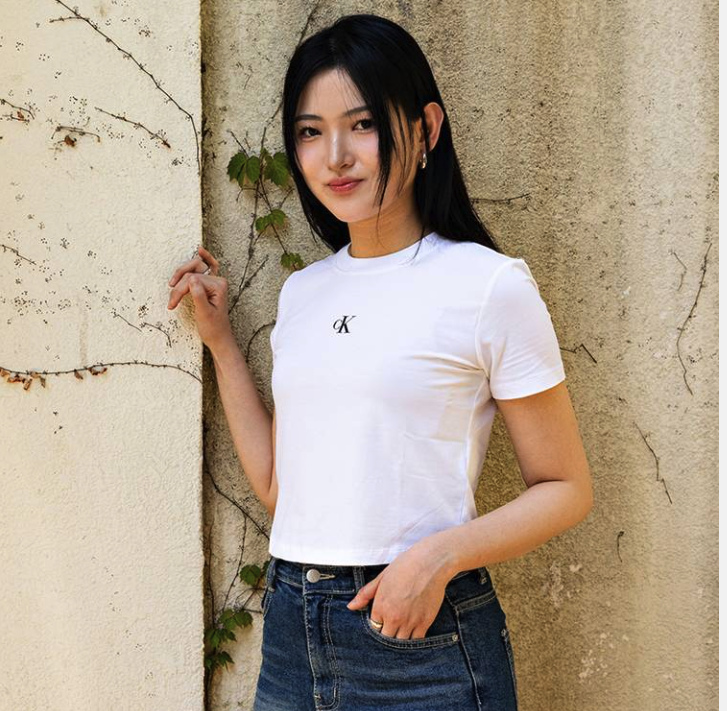

In [21]:
# invoke bedrock
multimodal_text_prompt = "Your role is a fashion analyst. \
Your task is to closely examine the given fashion image and identify the key visual elements and attributes. \
Extract details such as clothing items, patterns, materials, colors, styles, \
and any other notable features relevant to fashion analysis. \
Provide your comprehensive analysis in a structured JSON format, \
with the output in Korean, using appropriate labels and descriptions for each identified element or attribute"


target, associates = extract_properties_from_image(all_items,client,claude3_model_id,multimodal_text_prompt)                

# 3. 어울리는 상품 선택 및 이유 설명

## 프롬프트 작성

In [22]:
fasion_expert_promtpt = f"""You are a fashion expert. For the given <target_product> item, \
there is a list of related products in <associate_product>. \
From the <associate_product> list, identify the most suitable product for the target item \
and provide the reason for your selection. \

Instructions:
1. Please respond in JSON format in Korean.
2. Refer to the structure as below in <output_example>, but exclude the <output_example> tags themselves.    
3. Write "selected_product" in the form of summary simple as possible
4. Write "selected_image_path" given your selection from the <associate_product> list

<target_product>
{str(target)}
</target_product> 

<associate_product>
{str(associates)}
</associate_product>

<output_example>
"selected_image_path" : "tshirt_female_candidate03.jpg"
"reason" :
</output_example>
"""

## Claude3 Sonnet 모델로 이미지 선택 및 이유 설명

In [23]:
claude3_model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
response = invoke_claude3_sonnet_model(client = client, claude3_model_id = claude3_model_id,
                            prompt = fasion_expert_promtpt, image = None, multimodal=False)

- The model returned 1 response(s):
{
  "selected_product": "tshirt_female_candidate03.jpg",
  "selected_image_path": "../samples/sample_00/tshirt_female_candidate03.jpg",
  "reason": "이 제품은 데님 재킷과 잘 어울리는 심플하고 베이직한 화이트 반팔 티셔츠입니다. 티셔츠의 베이직한 디자인과 데님 재킷의 캐주얼한 스타일이 잘 매치되어 전체적으로 편안하고 자연스러운 데일리 룩을 연출할 수 있습니다. 또한 티셔츠의 화이트 색상은 블루 데님 재킷과 대비를 이루어 밝고 산뜻한 느낌을 줍니다."
}


reason 만을 변수에 넣고 보여주기

In [24]:
from eval_utils.util import print_ww
select_reason_sonnet =  parse_output_select_reason(response)    
print_ww(select_reason_sonnet)


이 제품은 데님 재킷과 잘 어울리는 심플하고 베이직한 화이트 반팔 티셔츠입니다. 티셔츠의 베이직한 디자인과 데님 재킷의 캐주얼한 스타일이 잘 매치되어 전체적으로 편안하고 자연스러운
데일리 룩을 연출할 수 있습니다. 또한 티셔츠의 화이트 색상은 블루 데님 재킷과 대비를 이루어 밝고 산뜻한 느낌을 줍니다.


## Claude3 Haiku 모델로 이미지 선택 및 이유 설명

In [25]:
claude3_model_id = "anthropic.claude-3-haiku-20240307-v1:0"
response = invoke_claude3_sonnet_model(client = client, claude3_model_id = claude3_model_id,
                            prompt = fasion_expert_promtpt, image = None, multimodal=False)

- The model returned 1 response(s):
{
  "selected_product": "반팔 티셔츠",
  "selected_image_path": "../samples/sample_00/tshirt_female_candidate03.jpg",
  "reason": "데님 재킷과 가장 잘 어울리는 아이템은 캐주얼하고 편안한 데일리 룩인 반팔 티셔츠입니다. 데님 재킷과 티셔츠의 조합은 전형적인 캐주얼 스타일을 연출할 수 있으며, 특히 이 반팔 티셔츠는 심플하고 베이직한 디자인으로 데님 재킷과 잘 어울립니다. 또한 청바지와 함께 착용하면 전체적으로 편안하고 자연스러운 분위기를 연출할 수 있습니다."
}


In [26]:

select_reason_haiku = parse_output_select_reason(response)    
print_ww(select_reason_haiku)

데님 재킷과 가장 잘 어울리는 아이템은 캐주얼하고 편안한 데일리 룩인 반팔 티셔츠입니다. 데님 재킷과 티셔츠의 조합은 전형적인 캐주얼 스타일을 연출할 수 있으며, 특히 이 반팔
티셔츠는 심플하고 베이직한 디자인으로 데님 재킷과 잘 어울립니다. 또한 청바지와 함께 착용하면 전체적으로 편안하고 자연스러운 분위기를 연출할 수 있습니다.


## Sonnet & Haiku 이유 비교

In [27]:
print("## Claude3 Sonnet")
print_ww(select_reason_sonnet)
print("\n## Claude3 Haiku")
print_ww(select_reason_haiku)

## Claude3 Sonnet
이 제품은 데님 재킷과 잘 어울리는 심플하고 베이직한 화이트 반팔 티셔츠입니다. 티셔츠의 베이직한 디자인과 데님 재킷의 캐주얼한 스타일이 잘 매치되어 전체적으로 편안하고 자연스러운
데일리 룩을 연출할 수 있습니다. 또한 티셔츠의 화이트 색상은 블루 데님 재킷과 대비를 이루어 밝고 산뜻한 느낌을 줍니다.

## Claude3 Haiku
데님 재킷과 가장 잘 어울리는 아이템은 캐주얼하고 편안한 데일리 룩인 반팔 티셔츠입니다. 데님 재킷과 티셔츠의 조합은 전형적인 캐주얼 스타일을 연출할 수 있으며, 특히 이 반팔
티셔츠는 심플하고 베이직한 디자인으로 데님 재킷과 잘 어울립니다. 또한 청바지와 함께 착용하면 전체적으로 편안하고 자연스러운 분위기를 연출할 수 있습니다.


In [28]:
%store select_reason_sonnet
%store select_reason_haiku

Stored 'select_reason_sonnet' (str)
Stored 'select_reason_haiku' (str)


# 다음 노트북을 실행 하세요
- [02_matching_reason_evaluation.ipynb](02_matching_reason_evaluation.ipynb)